In [7]:
import numpy as np
import torch
import matplotlib.pyplot as plt 
from scipy.stats import vonmises_fisher, multivariate_normal
from matplotlib.colors import Normalize
from vMF_distribution import VonMisesFisher
from pathlib import Path

np.random.default_rng() # reproducibility

%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
figure_folder = Path().resolve().parent / 'Slides' / 'figures'
figure_folder

WindowsPath('C:/Users/INES/Documents/3A_MVA/CompStats/projet-compstats-2023/Slides/figures')

In [3]:
%autoreload 2

## Test von Mises Fisher density and sampling

In [9]:
n_grid = 100
# create 2D grid in a spherical coordinate theta and phi
u = np.linspace(0, np.pi, n_grid)
v = np.linspace(0, 2 * np.pi, n_grid)
u_grid, v_grid = np.meshgrid(u, v)

# convert to cartesian coordinates
vertices = np.stack([np.cos(v_grid) * np.sin(u_grid),
                     np.sin(v_grid) * np.sin(u_grid),
                     np.cos(u_grid)],
                    axis=2)
print('vertices.shape:', vertices.shape)

x = np.outer(np.cos(v), np.sin(u)) # outer product of two vectors
y = np.outer(np.sin(v), np.sin(u))
z = np.outer(np.ones_like(u), np.cos(u))
print(f'x {x.shape}, y {y.shape}, z {z.shape}')

vertices.shape: (100, 100, 3)
x (100, 100), y (100, 100), z (100, 100)


pdf  0.005362131296362505
pdf  0.004793142934865656
pdf  0.004285015235449918
pdf  0.003831619891323754
pdf  0.0034273576988701955
pdf  0.0030671298846386722
pdf  0.0027463076445967665
pdf  0.0024607007508926225
pdf  0.0022065259312809065
pdf  0.0019803755904215566
pdf  0.0017791873211832846
pdf  0.0016002145479539875
pdf  0.0014409985523729434
pdf  0.001299342054093135
pdf  0.001173284454149227
pdf  0.0010610787950886462
pdf  0.000961170448985091
pdf  0.0008721775105448005
pdf  0.0007928728465146867
pdf  0.0007221677333488691
pdf  0.0006590970015115712
pdf  0.0006028055959130746
pdf  0.0005525364569192523
pdf  0.0005076196243775357
pdf  0.00046746246749927527
pdf  0.00043154094566379006
pdf  0.00039939180878616686
pdf  0.0003706056504235566
pdf  0.00034482073195997513
pdf  0.000321717501747518
pdf  0.0003010137387870414
pdf  0.00028246025624493505
pdf  0.00026583710570489465
pdf  0.000250950228457326
pdf  0.00023762850527343898
pdf  0.00022572116095696755
pdf  0.0002150954844915061
pd

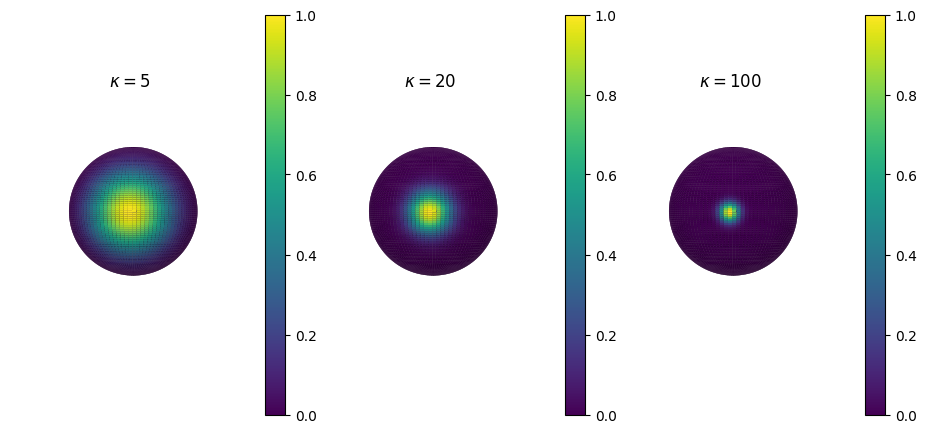

In [11]:
def plot_VMF_density(ax, x, y, z, vertices, mu, kappa):
    
    vmf = VonMisesFisher(mu, kappa)
    h, w = vertices.shape[:2]
    pdf_values = np.zeros((h, w))
    for i, j in np.ndindex(h, w):
        pdf_values[i, j] = vmf.pdf(torch.tensor(vertices[i, j]))
        print('pdf ', pdf_values[i, j])
    
    
    print(f' pdf values {pdf_values.max()}')

    pdfnorm = Normalize(vmin=pdf_values.min(), vmax=pdf_values.max())

    m = ax.plot_surface(x, y, z, rstride=1, cstride=1,
                    facecolors = plt.cm.viridis(pdfnorm(pdf_values)),
                    linewidth=0)
    plt.colorbar(m, ax=ax)
    ax.set_aspect('equal')
    ax.view_init(azim=-130, elev=0)
    ax.axis('off')
    ax.set_title(rf"$\kappa={kappa}$")


fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(9, 4),
                         subplot_kw={"projection": "3d"})
left, middle, right = axes
mu = torch.tensor([[-np.sqrt(0.5), -np.sqrt(0.5), 0]])
plot_VMF_density(left, x, y, z, vertices, mu, 5)
plot_VMF_density(middle, x, y, z, vertices, mu, 20)
plot_VMF_density(right, x, y, z, vertices, mu, 100)
plt.subplots_adjust(top=1, bottom=0.0, left=0.0, right=1.0, wspace=0.)
plt.show()

fig.savefig(figure_folder / 'vMF_density.png')

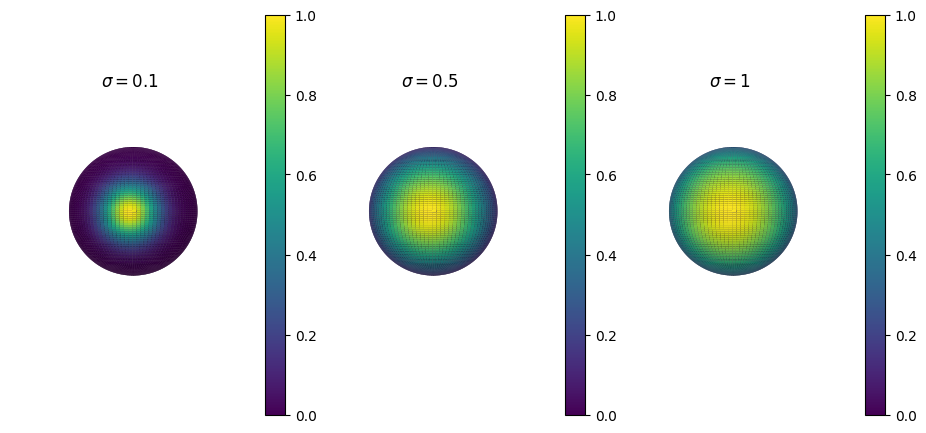

In [13]:
def plot_Normal_density(ax, x, y, z, vertices, mu, sigma):
    
    Sigma = sigma * torch.eye(3)

    h, w = vertices.shape[:2]
    pdf_values = np.zeros((h, w))
    for i, j in np.ndindex(h, w):
        pdf_values[i, j] = multivariate_normal.pdf(torch.tensor(vertices[i, j]), mean =  mu, cov = Sigma)    

    pdfnorm = Normalize(vmin=pdf_values.min(), vmax=pdf_values.max())

    m = ax.plot_surface(x, y, z, rstride=1, cstride=1,
                    facecolors = plt.cm.viridis(pdfnorm(pdf_values)),
                    linewidth=0)
    plt.colorbar(m, ax=ax)
    ax.set_aspect('equal')
    ax.view_init(azim=-130, elev=0)
    ax.axis('off')
    ax.set_title(rf"$\sigma={sigma}$")


fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(9, 4),
                         subplot_kw={"projection": "3d"})
left, middle, right = axes
mu = torch.tensor([-np.sqrt(0.5), -np.sqrt(0.5), 0])
plot_Normal_density(left, x, y, z, vertices, mu, .1)
plot_Normal_density(middle, x, y, z, vertices, mu, .5)
plot_Normal_density(right, x, y, z, vertices, mu, 1)
plt.subplots_adjust(top=1, bottom=0.0, left=0.0, right=1.0, wspace=0.)
plt.show()

fig.savefig(figure_folder / 'normal_density.png')

<class 'numpy.ndarray'>
samples  (20, 3)
<class 'numpy.ndarray'>
samples  (20, 3)
<class 'numpy.ndarray'>
samples  (20, 3)


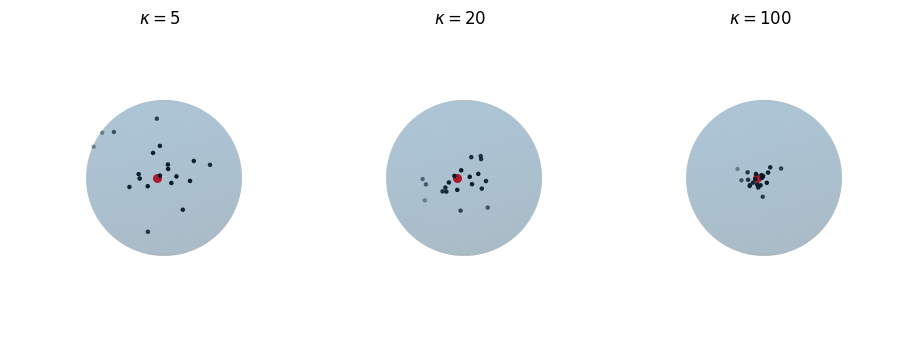

In [14]:
def plot_vmf_samples(ax, x, y, z, mu, kappa):
    vmf = vonmises_fisher(torch.tensor(mu), kappa)
    samples = vmf.rvs(20)
    print(type(samples))
    print('samples ', samples.shape)
    ax.plot_surface(x, y, z, rstride=1, cstride=1, linewidth=0,
                    alpha=0.2) # rstride, cstride : downsampling stride in each direction to determine the number of point to be plotted
    ax.scatter(samples[:, 0], samples[:, 1], samples[:, 2], c='k', s=5)
    ax.scatter(mu[0], mu[1], mu[2], c='r', s=30)
    ax.set_aspect('equal')
    ax.view_init(azim=-130, elev=0)
    ax.axis('off')
    ax.set_title(rf"$\kappa={kappa}$")


mu = np.array([-np.sqrt(0.5), -np.sqrt(0.5), 0])
fig, axes = plt.subplots(nrows=1, ncols=3,
                         subplot_kw={"projection": "3d"},
                         figsize=(9, 4))
left, middle, right = axes
plot_vmf_samples(left, x, y, z, mu, 5)
plot_vmf_samples(middle, x, y, z, mu, 20)
plot_vmf_samples(right, x, y, z, mu, 100)
plt.subplots_adjust(top=1, bottom=0.0, left=0.0,
                    right=1.0, wspace=0.)
plt.show()

fig.savefig(figure_folder / 'vMF_sampling_scipy.png')

mus  torch.Size([1, 3])
kappas  torch.Size([1])
w torch.Size([20, 1])
samples  torch.Size([1, 20, 3])
mus  torch.Size([1, 3])
kappas  torch.Size([1])
w torch.Size([20, 1])
samples  torch.Size([1, 20, 3])
mus  torch.Size([1, 3])
kappas  torch.Size([1])
w torch.Size([20, 1])
samples  torch.Size([1, 20, 3])


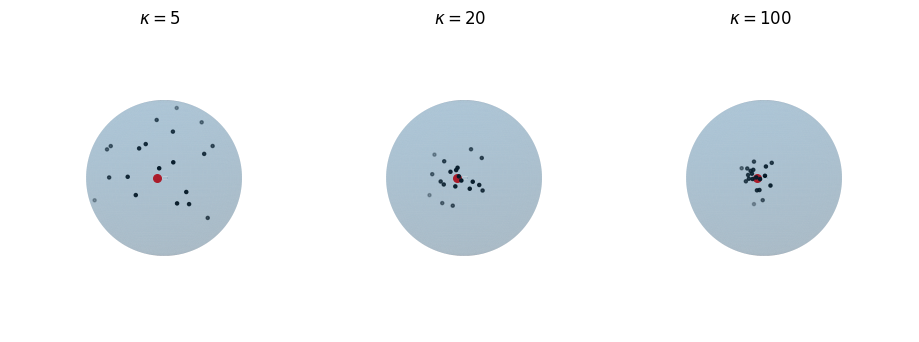

In [39]:
def plot_vmf_samples_ours(ax, x, y, z, mus, kappa):
    n_samples = 20

    print('mus ', mus.shape)
    kappas = torch.tensor([kappa])
    print('kappas ', kappas.shape)
    vmf = VonMisesFisher(mus, kappas)
    samples, _, _, _ = vmf.sample(n_samples=n_samples)
    print('samples ', samples.shape)
    
    ax.plot_surface(x, y, z, rstride=1, cstride=1, linewidth=0,
                    alpha=0.2) # rstride, cstride : downsampling stride in each direction to determine the number of point to be plotted
    ax.scatter(samples[0, :, 0], samples[0, :, 1], samples[0, :, 2], c='k', s=5)
    ax.scatter(mus[0, 0], mus[0,1], mus[0, 2], c='r', s=30)
    ax.set_aspect('equal')
    ax.view_init(azim=-130, elev=0)
    ax.axis('off')
    ax.set_title(rf"$\kappa={kappa}$")

mu = torch.tensor([[-np.sqrt(0.5), -np.sqrt(0.5), 0]])
fig, axes = plt.subplots(nrows=1, ncols=3,
                         subplot_kw={"projection": "3d"},
                         figsize=(9, 4))
left, middle, right = axes
plot_vmf_samples_ours(left, x, y, z, mu, 5)
plot_vmf_samples_ours(middle, x, y, z, mu, 20)
plot_vmf_samples_ours(right, x, y, z, mu, 100)
plt.subplots_adjust(top=1, bottom=0.0, left=0.0,
                    right=1.0, wspace=0.)
plt.show()
fig.savefig(figure_folder / 'vMF_sampling_ours.png')

samples  (50, 3)
samples  (50, 3)
samples  (50, 3)


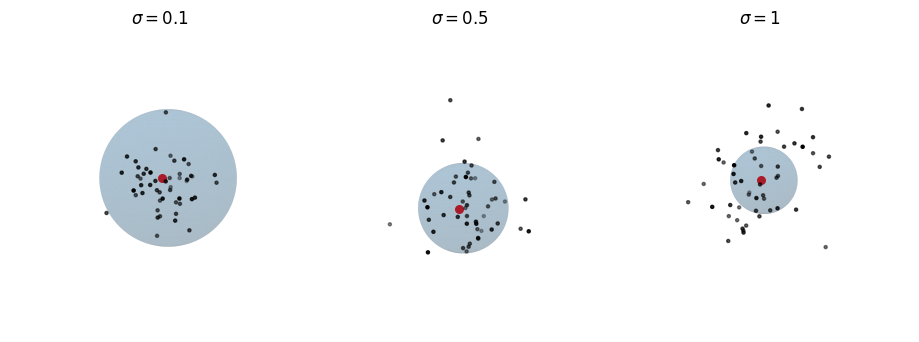

In [16]:
def plot_normal_samples(ax, x, y, z, mu, sigma):

    samples = multivariate_normal.rvs(mean=mu, cov=sigma, size=50)
    print('samples ', samples.shape)
    ax.plot_surface(x, y, z, rstride=1, cstride=1, linewidth=0,
                    alpha=0.2) # rstride, cstride : downsampling stride in each direction to determine the number of point to be plotted
    ax.scatter(samples[:, 0], samples[:, 1], samples[:, 2], c='k', s=5)
    ax.scatter(mu[0], mu[1], mu[2], c='r', s=30)
    ax.set_aspect('equal')
    ax.view_init(azim=-130, elev=0)
    ax.axis('off')
    ax.set_title(rf"$\sigma={sigma}$")


mu = np.array([-np.sqrt(0.5), -np.sqrt(0.5), 0])
fig, axes = plt.subplots(nrows=1, ncols=3,
                         subplot_kw={"projection": "3d"},
                         figsize=(9, 4))
left, middle, right = axes
plot_normal_samples(left, x, y, z, mu, .1)
plot_normal_samples(middle, x, y, z, mu, .5)
plot_normal_samples(right, x, y, z, mu, 1)
plt.subplots_adjust(top=1, bottom=0.0, left=0.0,
                    right=1.0, wspace=0.)
plt.show()

fig.savefig(figure_folder / 'normal_sampling.png')